In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print(f"Old working dir {os.getcwd()}")
os.chdir('../')
print(f"New working dir {os.getcwd()}")

Old working dir /home/alex/repos/conditional_quantile_function/poc
New working dir /home/alex/repos/conditional_quantile_function


In [3]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [4]:
from conformal.real_datasets.reproducible_split import get_dataset_split
from conformal.classes.method_desc import ConformalMethodDescription
from conformal.wrappers.cvq_regressor import CVQRegressor

In [5]:
alpha = 0.3
scale = 0.1
n = 10000
rng = np.random.default_rng(31337)
x = np.linspace(0, 1, n)
y_true =  x ** 1.6
y = y_true + rng.normal(scale=scale, size=n)
interval_1a = norm.interval(1 - alpha, loc=0, scale=scale)

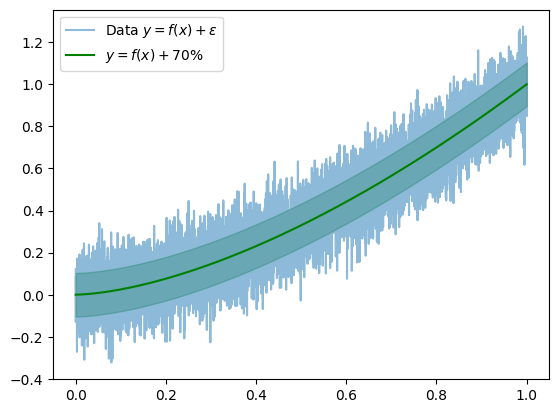

In [6]:
plt.plot(x, y, label=r"Data $y=f(x)+\epsilon$", alpha=0.5)
plt.plot(x, y_true, "g", label=rf'$y=f(x) + {int((1 - alpha) * 100)}\%$')
plt.fill_between(x, y_true + interval_1a[0], y_true + interval_1a[1], color="g", alpha=0.3)
#plt.plot(x, x, "k--", label=r'$y=x$')
plt.legend()

In [7]:
reg = CVQRegressor(
    feature_dimension=1,
    response_dimension=1,
    hidden_dimension=8,
    number_of_hidden_layers=4,
    batch_size=512,
    n_epochs=150,
    learning_rate=0.01,
    dtype=torch.float32,
    betas=(0.5, 0.5),
    weight_decay=1e-4,
    warmup_iterations=5
)
fn_model = "cvqregressor_for_1d_check_hpd.pth"

In [8]:
if os.path.isfile(fn_model):
    reg.model.load(fn_model)
else:
    reg.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    reg.model.eval()
    reg.model.save(fn_model)

In [9]:
#reg.model.eval()

In [10]:
y_pred = reg.predict_mean(x.reshape(-1, 1))
interval_99 = norm.interval(1 - alpha, loc=0, scale=1)
y_pred_low = reg.predict_inverse_quantile(x.reshape(-1, 1), np.repeat(interval_99[0], repeats=n, axis=0).reshape(-1, 1))
y_pred_high = reg.predict_inverse_quantile(x.reshape(-1, 1), np.repeat(interval_99[1], repeats=n, axis=0).reshape(-1, 1))

In [11]:
y_pred_low.shape, y_pred_high.shape

((10000, 1), (10000, 1))

In [12]:
y_pred_low[:5]

array([[-0.09547931],
       [-0.09546047],
       [-0.09544182],
       [-0.09542304],
       [-0.09540427]], dtype=float32)

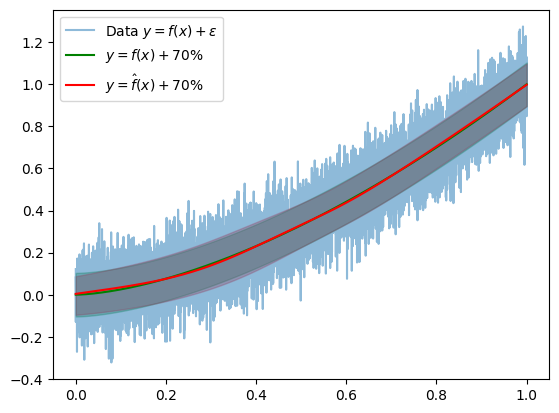

In [13]:
plt.plot(x, y, label=r"Data $y=f(x)+\epsilon$", alpha=0.5)
plt.plot(x, y_true, "g", label=rf'$y=f(x) + {int((1 - alpha) * 100)}\%$')
plt.plot(x, y_pred, "r", label=rf'$y=\hat{{f}}(x) + {int((1 - alpha) * 100)}\%$')
plt.fill_between(x, y_true + interval_1a[0], y_true + interval_1a[1], color="g", alpha=0.3)
plt.fill_between(x, y_pred_low[:, 0], y_pred_high[:, 0], color="r", alpha=0.3)
#plt.plot(x, x, "k--", label=r'$y=x$')
plt.legend()

In [14]:
quantiles = reg.predict_quantile(x.reshape(-1, 1), y.reshape(-1, 1))

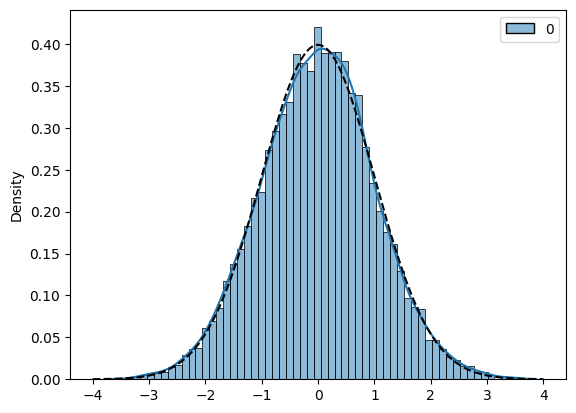

In [15]:
t = np.linspace(-4, 4, 1000)
sns.histplot(quantiles, kde=True, stat="density")
plt.plot(t, norm.pdf(t), "k--")

In [16]:
# Look at log density at the point x = 0.5
x0 = 0.9 * np.ones((1000, 1))
#u_sample = rng.random.normal(size=1000)
scores = reg.calculate_scores(x0.reshape(-1, 1), t.reshape(-1, 1))

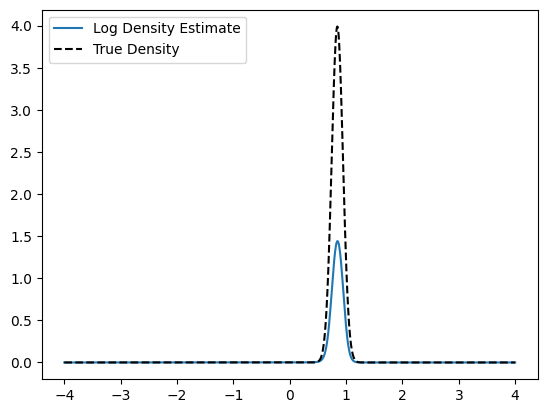

In [17]:
plt.plot(t, np.exp(scores["Log Density"]), label="Log Density Estimate") #scores["Log Density"]
plt.plot(t, norm.pdf(t, loc=x0[0]**1.6, scale=scale), "k--", label="True Density")
plt.legend()
plt.show()